# Plot GSM-Symbolic Tuning Accuracies

Plots accuracy on the GSM-symbolic dataset for directions derived from each task (`chess`, `arithmetic-base8`, `programming`) and the averaged `combined` direction, across layers.


In [1]:
from __future__ import annotations
import json
from pathlib import Path
from typing import Dict, List

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

BASE = Path('/home/ljilesen/interaction-experiment')

METRIC_PATHS = {
    'chess': BASE / 'outputs/chess/tuning/counter_factual/gsm_tuning_metrics.json',
    'arithmetic-base8': BASE / 'outputs/arithmetic-base8/tuning/counter_factual/gsm_tuning_metrics.json',
    'programming': BASE / 'outputs/programming/tuning/counter_factual/gsm_tuning_metrics.json',
    'combined': BASE / 'outputs/combined/tuning/counter_factual/gsm_tuning_metrics.json',
}

assert all(p.exists() for p in METRIC_PATHS.values()), 'One or more metrics files are missing.'


In [2]:
def load_metrics(path: Path) -> dict:
    with path.open('r') as f:
        return json.load(f)


def metrics_to_df(task: str, data: dict) -> pd.DataFrame:
    rows = []
    metrics = data.get('metrics', {})
    for layer_str, alpha_dict in metrics.items():
        for alpha_str, acc in alpha_dict.items():
            try:
                layer = int(layer_str)
                alpha = float(alpha_str)
            except Exception:
                continue
            rows.append({'task': task, 'layer': layer, 'alpha': alpha, 'accuracy': float(acc)})
    df = pd.DataFrame(rows)
    if not df.empty:
        df.sort_values(['layer', 'alpha'], inplace=True)
    return df


def load_all_as_df(paths: Dict[str, Path]) -> pd.DataFrame:
    frames: List[pd.DataFrame] = []
    for task, path in paths.items():
        data = load_metrics(path)
        frames.append(metrics_to_df(task, data))
    return pd.concat(frames, ignore_index=True)


df = load_all_as_df(METRIC_PATHS)
# Use alpha=0.1 only (grid contains only 0.1 in these runs)
df_alpha = df[df['alpha'] == 0.1].copy()
df_alpha.head()


,task,layer,alpha,accuracy
0,chess,0,0.1,0.44
1,chess,1,0.1,0.52
2,chess,2,0.1,0.55
3,chess,3,0.1,0.52
4,chess,4,0.1,0.54


In [ ]:
# List saved files
saved_paths


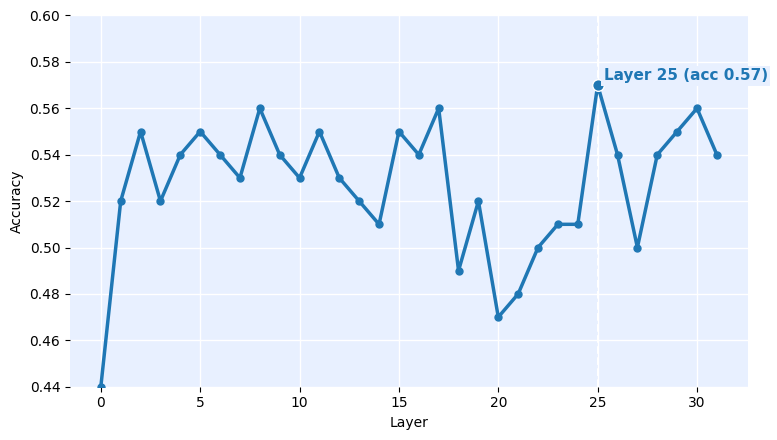

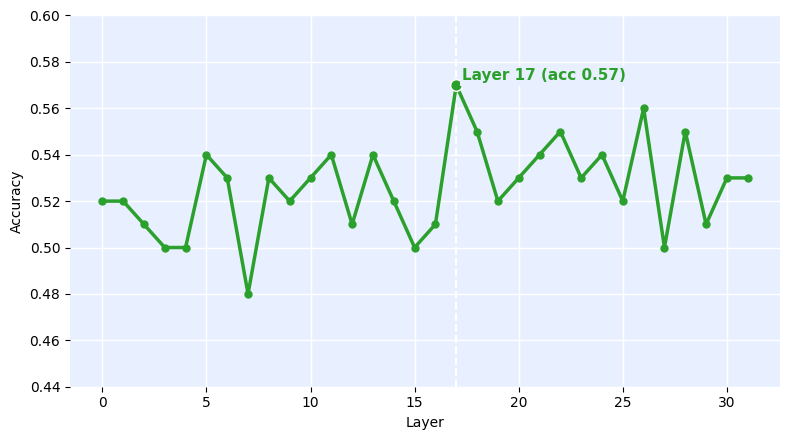

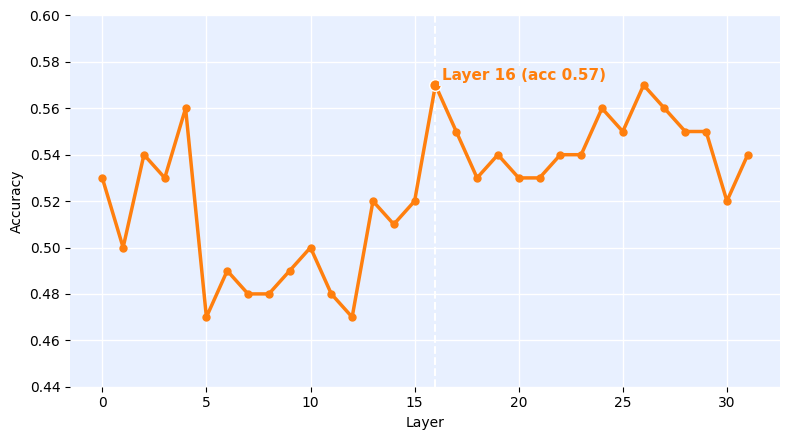

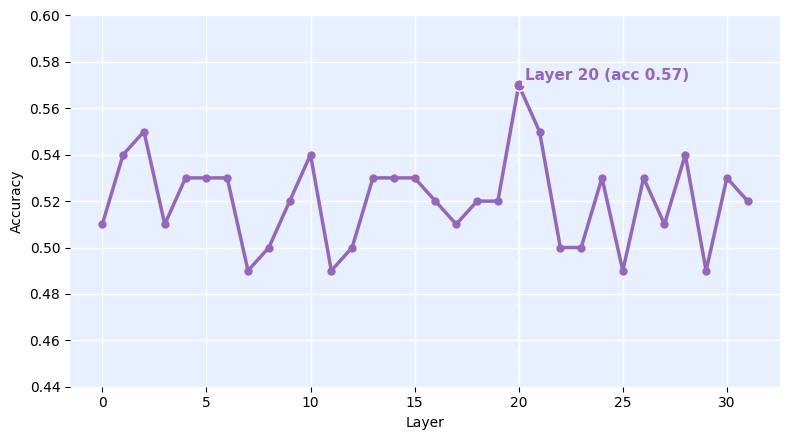

In [7]:
# Re-plot with white outer background and blue grid only inside axes
light_blue = '#e8f0ff'
out_dir = BASE / 'figures'
out_dir.mkdir(parents=True, exist_ok=True)
saved_paths = []

palette = {
    'chess': '#1f77b4',
    'arithmetic-base8': '#2ca02c',
    'programming': '#ff7f0e',
    'combined': '#9467bd',
}

best_by_task = {}
for task, path in METRIC_PATHS.items():
    data = load_metrics(path)
    best = data.get('best', {})
    if best:
        best_by_task[task] = {'layer': int(best.get('layer')), 'metric': float(best.get('metric'))}
    else:
        # Fallback: compute from df
        sub = df_alpha[df_alpha['task'] == task]
        if not sub.empty:
            idx = sub['accuracy'].idxmax()
            best_by_task[task] = {'layer': int(sub.loc[idx, 'layer']), 'metric': float(sub.loc[idx, 'accuracy'])}

for task in ['chess', 'arithmetic-base8', 'programming', 'combined']:
    sub = df_alpha[df_alpha['task'] == task].sort_values('layer')
    fig, ax = plt.subplots(figsize=(8, 4.5))
    fig.patch.set_facecolor('white')
    ax.set_facecolor(light_blue)

    ax.plot(
        sub['layer'],
        sub['accuracy'],
        color=palette.get(task),
        marker='o',
        markersize=5,
        linewidth=2.5,
    )

    best = best_by_task.get(task)
    if best is not None:
        ax.axvline(best['layer'], color='white', linestyle='--', linewidth=1.5, zorder=1)
        ax.scatter([best['layer']], [best['metric']], color=palette.get(task), edgecolor='white', s=70, zorder=3)
        ax.text(best['layer'] + 0.3, best['metric'] + 0.002, f"Layer {best['layer']} (acc {best['metric']:.2f})",
                color=palette.get(task), fontsize=11, weight='bold', bbox=dict(facecolor=light_blue, edgecolor='none', pad=2))

    ax.grid(True, color='white', linewidth=1.0)
    for spine in ax.spines.values():
        spine.set_visible(False)

    #ax.set_title(f'{name_map[task]}: GSM-symbolic tuning across layers')
    ax.set_xlabel('Layer')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0.44, max(0.60, sub['accuracy'].max() + 0.02))

    fig.tight_layout()
    fig_path = out_dir / f'gsm_symbolic_tuning_{task}.png'
    fig.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
    saved_paths.append(fig_path)
    plt.show()
